<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [6]:
library(zoo)
library(lmtest)

https://stats.stackexchange.com/questions/258485/simulate-linear-regression-with-heteroscedasticity

To simulate data with a varying error variance, you need to specify the data generating process for the error variance. As has been pointed out in the comments, you did that when you generated your original data. If you have real data and want to try this, you just need to identify the function that specifies how the residual variance depends on your covariates. The standard way to do that is to fit your model, check that it is reasonable (other than the heteroscedasticity), and save the residuals. Those residuals become the Y variable of a new model. Below I have done that for your data generating process. (I don't see where you set the random seed, so these won't literally be the same data, but should be similar, and you can reproduce mine exactly by using my seed.)


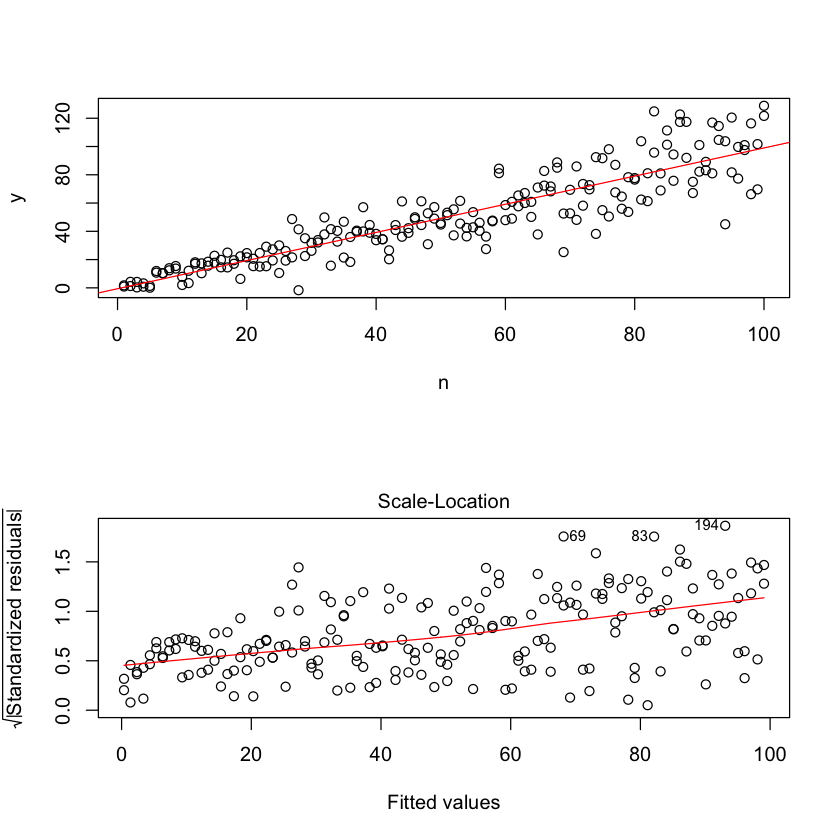

In [7]:
set.seed(568)  # this makes the example exactly reproducible

n      = rep(1:100,2)
a      = 0
b      = 1
sigma2 = n^1.3
eps    = rnorm(n,mean=0,sd=sqrt(sigma2))
y      = a+b*n + eps
mod    = lm(y ~ n)
res    = residuals(mod)


layout(matrix(1:2, nrow=2))
plot(n,y)
abline(coef(mod), col="red")
plot(mod, which=3)

Note that R's ?plot.lm will give you a plot (cf., here) of the square root of the absolute values of the residuals, helpfully overlaid with a lowess fit, which is just what you need. (If you have multiple covariates, you might want to assess this against each covariate separately.) There is the slightest hint of a curve, but this looks like a straight line does a good job of fitting the data. So let's explicitly fit that model:

In [8]:
res.mod = lm(sqrt(abs(res))~fitted(mod))
summary(res.mod)


Call:
lm(formula = sqrt(abs(res)) ~ fitted(mod))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3912 -0.7640  0.0794  0.8764  3.2726 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.669571   0.181361   9.206  < 2e-16 ***
fitted(mod) 0.023558   0.003157   7.461 2.64e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.285 on 198 degrees of freedom
Multiple R-squared:  0.2195,	Adjusted R-squared:  0.2155 
F-statistic: 55.67 on 1 and 198 DF,  p-value: 2.641e-12


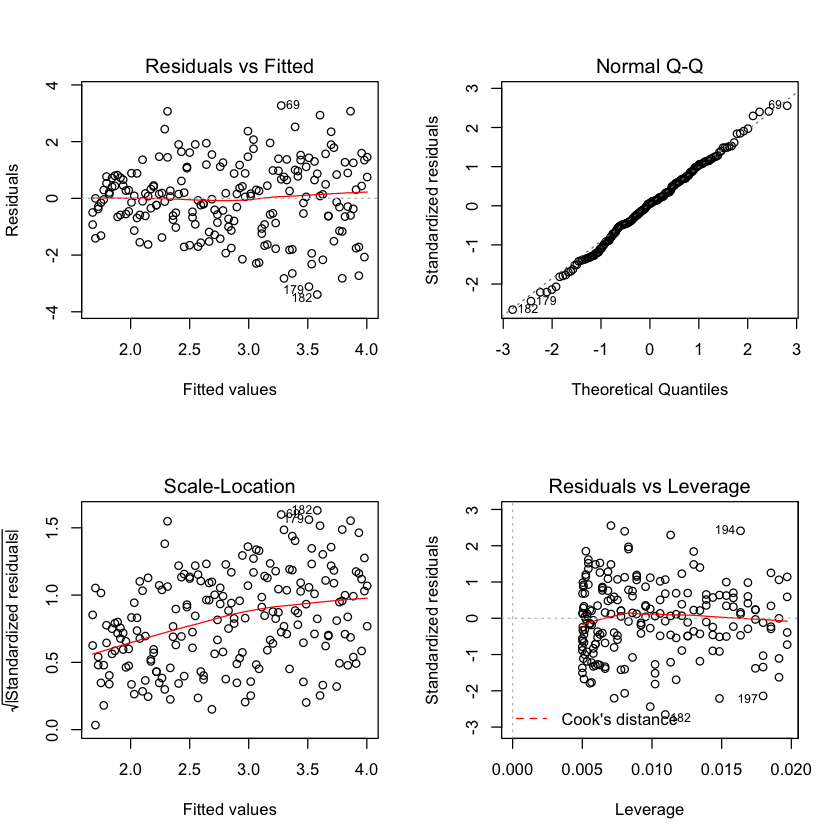

In [10]:
layout(matrix(1:4, nrow=2, ncol=2, byrow=TRUE))
plot(res.mod, which=1)
plot(res.mod, which=2)
plot(res.mod, which=3)
plot(res.mod, which=5)

We needn't be concerned that the residual variance seems to be increasing in the scale-location plot for this model as well—that essentially has to happen. There is again the slightest hint of a curve, so we can try to fit a squared term and see if that helps (but it doesn't):

In [11]:
res.mod2 = lm(sqrt(abs(res))~poly(fitted(mod), 2))
summary(res.mod2)
# output omitted
anova(res.mod, res.mod2)


Call:
lm(formula = sqrt(abs(res)) ~ poly(fitted(mod), 2))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3928 -0.7587  0.0782  0.8800  3.2776 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.84074    0.09108  31.189  < 2e-16 ***
poly(fitted(mod), 2)1  9.58678    1.28808   7.443 2.99e-12 ***
poly(fitted(mod), 2)2  0.10754    1.28808   0.083    0.934    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.288 on 197 degrees of freedom
Multiple R-squared:  0.2195,	Adjusted R-squared:  0.2116 
F-statistic:  27.7 on 2 and 197 DF,  p-value: 2.507e-11


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
198,326.8657,NA,NA,NA,NA
197,326.8541,1,0.01156409,0.006969855,0.9335502


If we're satisfied with this, we can now use this process as an add-on to simulate data.

In [12]:
set.seed(4396)  # this makes the example exactly reproducible
x = n
expected.y = coef(mod)[1] + coef(mod)[2]*x
sim.errors = rnorm(length(x), mean=0,
                   sd=(coef(res.mod)[1] + coef(res.mod)[2]*expected.y)^2)
observed.y = expected.y + sim.errors

Note that this process is no more guaranteed to find the true data generating process than any other statistical method. You used a non-linear function to generate the error SDs, and we approximated it with a linear function. If you actually know the true data generating process a-priori (as in this case, because you simulated the original data), you might as well use it. You can decide if the approximation here is good enough for your purposes. We typically don't know the true data generating process, however, and based on Occam's razor, go with the simplest function that adequately fits the data we have given the amount of information available. You can also try splines or fancier approaches if you prefer. The bivariate distributions look reasonably similar to me, but we can see that while the estimated function largely parallels the true function, they do not overlap:
    
![](image1.png)